<h2> Stock Market Prediction Using LSTM Networks </h2>

In [ ]:
# Importing the necessary libraries.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA

# Import the gold.csv file
df = pd.read_csv('tesla.csv')

# Display the first 5 rows of the dataframe
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [2]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3682.000000,3682.000000,3682.000000,3682.000000,3.682000e+03,3682.0,3682.000000
mean,84.068473,85.916742,82.091640,84.042719,9.651920e+07,0.0,0.002173
std,110.838840,113.321844,108.110895,110.747440,7.744906e+07,0.0,0.096083
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,12.233500,12.439501,11.978500,12.193166,4.923488e+07,0.0,0.000000
50%,18.172667,18.461000,17.867667,18.229000,8.195580e+07,0.0,0.000000
75%,182.075005,185.197498,177.367504,181.355003,1.216603e+08,0.0,0.000000
max,475.899994,488.540009,457.510010,479.859985,9.140820e+08,0.0,5.000000


<p> The standard deviation (std) in the `describe()` function quantifies the variation or dispersion within the data set. A higher standard deviation signifies that the 

data points are dispersed over a broader range of values. In contrast, a lower standard deviation indicates that the data points cluster closely around the mean. </p>


<p> Standard Deviation for Key Columns

- Open: The standard deviation is 110.838840, indicating that the opening prices exhibit considerable variability from the mean opening price of 84.068473.
- High: The standard deviation is 113.321844, demonstrating that the highest prices throughout the day also show significant fluctuations around the mean of 85.916742.
- Low: The standard deviation is 108.110895, suggesting that the lowest prices during the day are similarly spread around the mean of 82.091640.
- Close: The standard deviation is 110.747440, indicating that the closing prices vary significantly around the mean closing price of 84.042719.

Other Columns:
- Volume: The standard deviation is 7.744906e+07, reflecting a substantial variation in trading volume compared to the mean of 9.651920e+07.
- Dividends: The standard deviation is 0.0, which signifies no variation in dividend values, as all entries are uniformly 0.
- Stock Splits: The standard deviation is 0.096083, indicating minimal variation around the mean of 0.002173.</p>

<h3> Data Cleaning </h3>

In [3]:
df.reset_index(drop=True, inplace=True) # Resetting the index.
df.sort_values(by='Date', ascending=True, inplace=True) # Sorting the data by 'Date' in ascending order.

df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True) # Converting the 'Date' column to datetime.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          3682 non-null   datetime64[ns, UTC]
 1   Open          3682 non-null   float64            
 2   High          3682 non-null   float64            
 3   Low           3682 non-null   float64            
 4   Close         3682 non-null   float64            
 5   Volume        3682 non-null   int64              
 6   Dividends     3682 non-null   float64            
 7   Stock Splits  3682 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 230.2 KB


<h3> Visualisation of the data </h3>

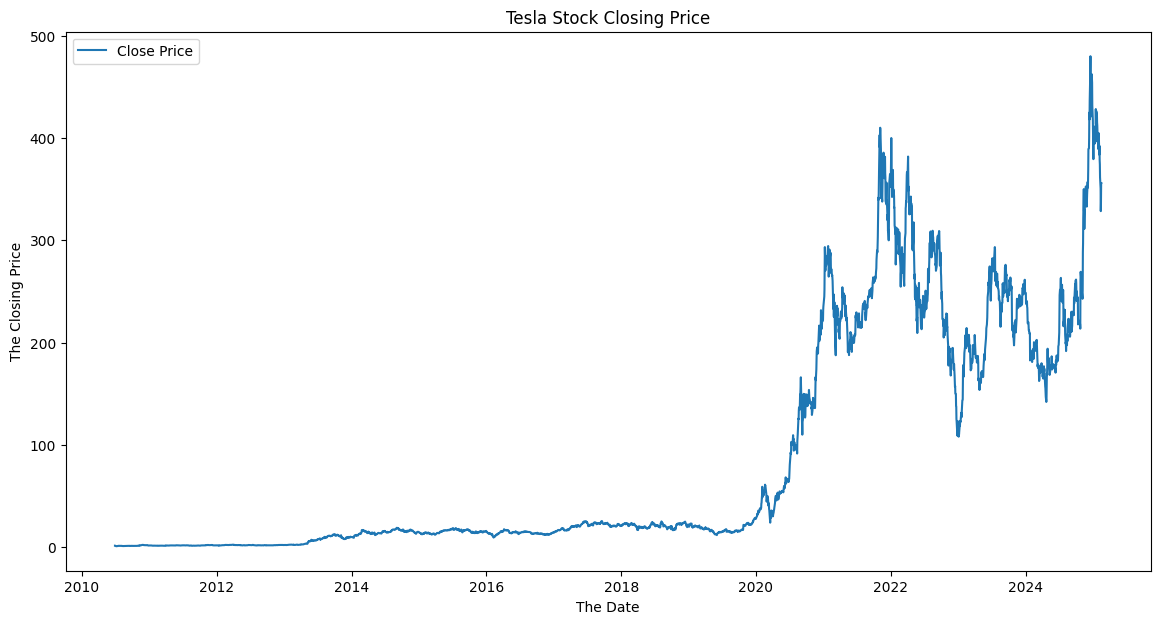

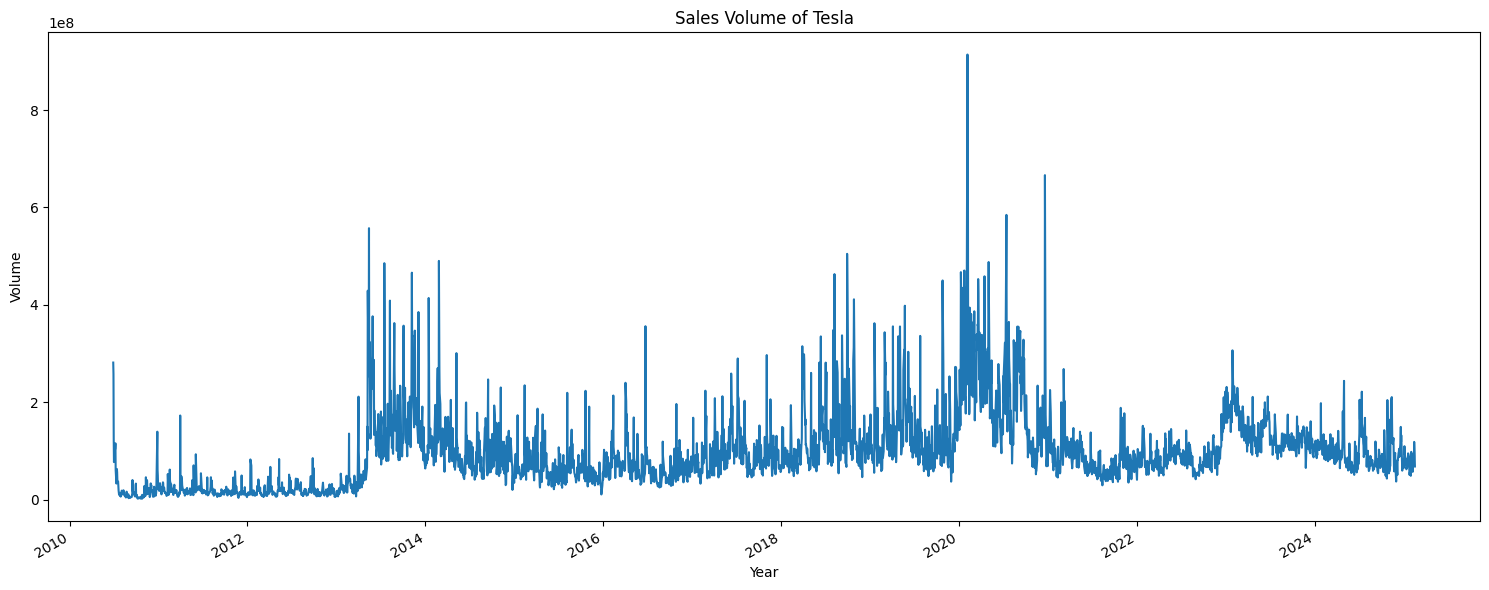

In [4]:
# Visualise the closing price of the stock.
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Tesla Stock Closing Price') 
plt.xlabel('The Date') 
plt.ylabel('The Closing Price')
plt.legend()
plt.show() 

# visualise the volume of stocks sold each year
plt.figure(figsize=(15, 6))
df.set_index('Date')['Volume'].plot()
plt.xlabel('Year')
plt.ylabel('Volume')
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

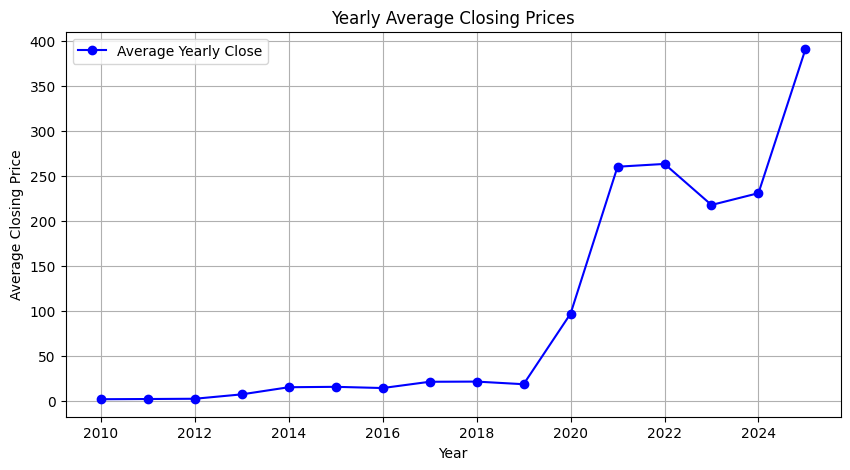

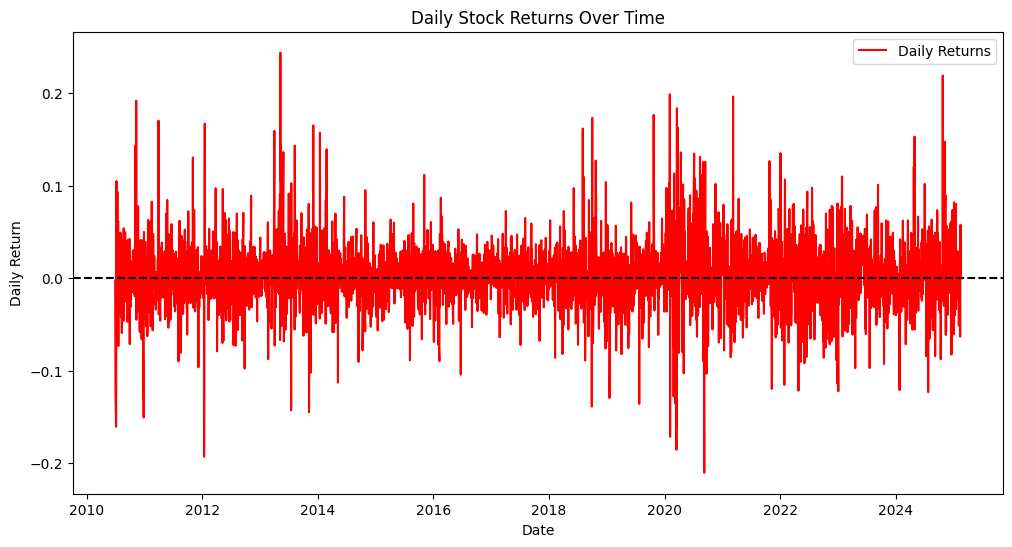

In [5]:
# Extract year and calculate average closing price per year
df['Year'] = df['Date'].dt.year
yearly_avg = df.groupby('Year')['Close'].mean()

# Plot the data
plt.figure(figsize=(10,5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-', color='b', label='Average Yearly Close')
plt.xlabel('Year')
plt.ylabel('Average Closing Price')
plt.title('Yearly Average Closing Prices')
plt.legend()
plt.grid()
plt.show()

# Daily stock returns.
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Daily Return'], color="red", label="Daily Returns")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Stock Returns Over Time")
plt.legend()
plt.show()

In [6]:
print(df['Daily Return'].std()) # Standard deviation of the daily returns.

0.03614465161068758


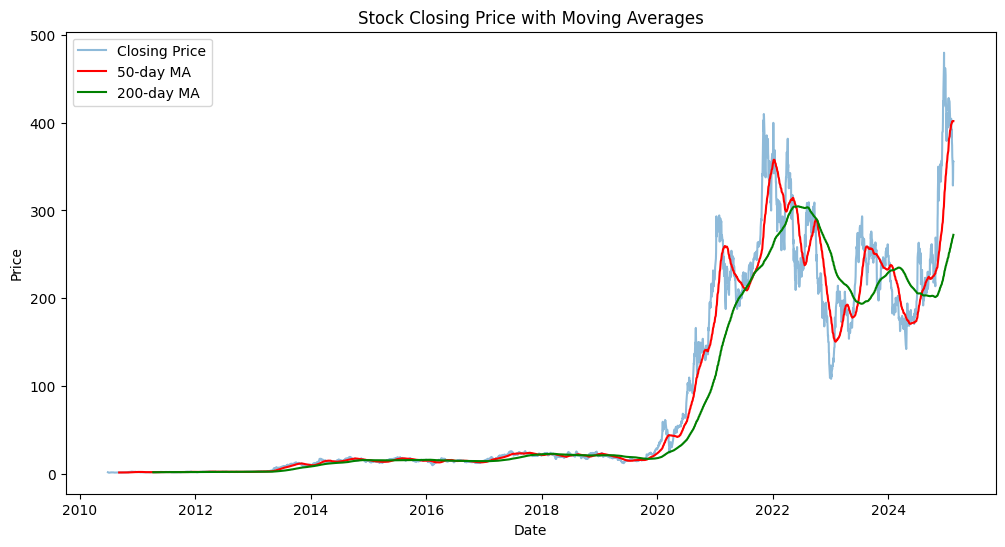

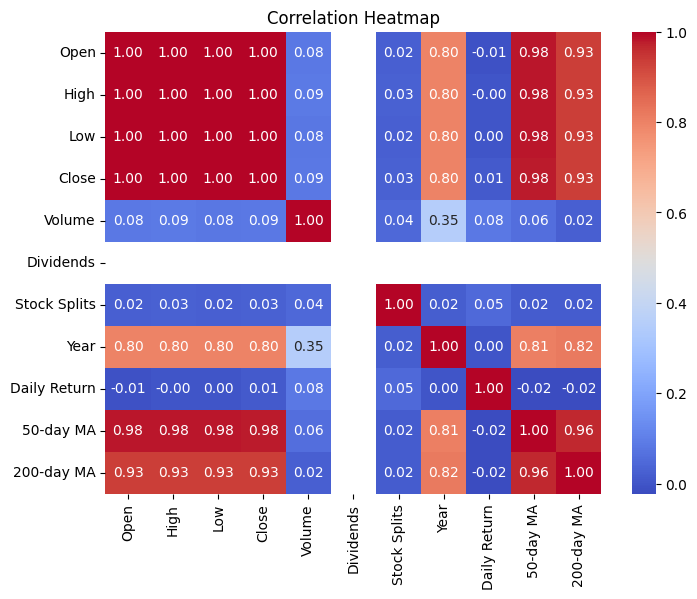

In [7]:
# Calculate the moving averages.
df['50-day MA'] = df['Close'].rolling(window=50).mean()
df['200-day MA'] = df['Close'].rolling(window=200).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Closing Price", alpha=0.5)
plt.plot(df['Date'], df['50-day MA'], label="50-day MA", color="red")
plt.plot(df['Date'], df['200-day MA'], label="200-day MA", color="green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Closing Price with Moving Averages")
plt.legend()
plt.show()

# Drop non-numeric columns.
df_numeric = df.select_dtypes(include=['number'])

# Calculate the correlation matrix.
corr_matrix = df_numeric.corr()

# Plot the correlation heatmap.
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<p> Price-related variables, namely Open, High, Low, and Close, exhibit a high correlation (approximately ~1.00). This is understandable, as these values typically move in tandem with stock prices.

The 50-day moving average (MA) and 200-day MA show a strong correlation (around ~0.96-0.98) with stock prices. Moving averages serve to smooth price trends and inherently follow price movements. In contrast, trading volume demonstrates only a weak correlation (ranging from ~0.08 to 0.35) with price changes, indicating that volume does not significantly impact price fluctuations. Daily returns exhibit minimal correlation with other features (approximately ~-0.02 to 0.05), suggesting that stock returns fluctuate relatively independently of individual price points. 

Finally, the year variable reflects a moderate correlation (around ~0.80) with stock prices, which may indicate an upward trend over time.</p>

<Axes: title={'center': 'Monthly Average Closing Price'}, xlabel='Month'>

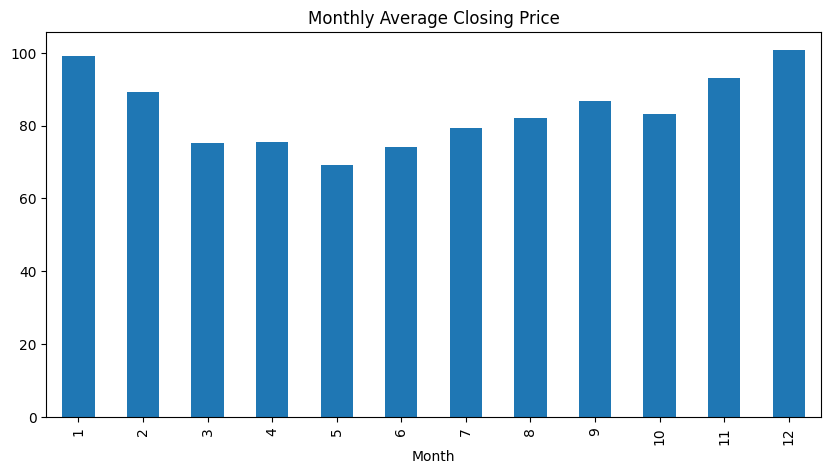

In [8]:
# Sentiment Analysis.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)  # Force UTC.
df['Month'] = df['Date'].dt.month 
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Close'].mean()
monthly_avg.plot(kind='bar', title="Monthly Average Closing Price", figsize=(10,5))

<p>
The graph depicts the monthly average closing price, starting and finishing at 100, with significant fluctuations observed throughout the year. A downward trend begins in month two, gradually declining until it drops sharply in month five, representing the period's lowest point. This mid-year decline suggests a temporary market correction or the influence of external economic factors. Nevertheless, the recovery by the year's end demonstrates resilience and a return to stability. Overall, the observed pattern illustrates cyclical volatility, wherein prices are influenced by seasonal trends, market events, or investor behaviour, ultimately regaining strength by year-end.
</p>

<h3> Building the LSTM Model </h3>

<p>
Two Types of model which will be built:

1. Will be trained on close price
   
   Try 80-20 split

   Try 70-30 split


2. Will be trained on close and open price

   Try 80-20 split
   
   Try 70-30 split

</p>

<h4> Train The Model on Close Price 80 - 20 Spilt   </h4>

In [ ]:
df.head()

In [ ]:
# Convert Date column to datetime and sort the data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Select only the 'Close' price
close_model_df = df[['Date', 'Close']]

# Normalize the 'Close' column
scaler = MinMaxScaler(feature_range=(0,1))
close_model_df['Close'] = scaler.fit_transform(close_model_df[['Close']])

# Display first few rows
close_model_df.head()

In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Last `seq_length` days
        y.append(data[i + seq_length])   # Predict next day
    return np.array(X), np.array(y)

# Convert Close column to NumPy array
close_prices = close_model_df['Close'].values

# Define sequence length (e.g., 50 days)
seq_length = 50

# Create sequences
X, y = create_sequences(close_prices, seq_length)

# Split into training (80%) and testing (20%) sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

<p>

Layer Type Purpose

LSTM (50 units, return_sequences=True) First LSTM layer that learns patterns from past 50 days. We return sequences because another LSTM layer follows.

Dropout (0.2) Randomly drops 20% of neurons to prevent overfitting.

LSTM (50 units, return_sequences=False) Second LSTM layer (final one) that extracts meaningful features. We set return_sequences=False because no more LSTM layers follow.

Dropout (0.2) Another dropout to prevent overfitting.

Dense (25 units, activation='relu') A fully connected layer with 25 neurons to transform LSTM features into a meaningful representation.

Dense (1 unit) Output layer that predicts the next day’s stock price.

</p>

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(50, 1)),  # LSTM layer with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),  # Another LSTM layer
    Dropout(0.2),
    Dense(25, activation='relu'),  # Dense layer with 25 neurons
    Dense(1)  # Output layer (predict next close price)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

In [ ]:
# Define early stopping to stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,  # We can set a high number, and early stopping will stop it earlier
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on the test set
mse, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse the normalization (convert back to actual price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

<h4> Train The Model on Close & Volume 80 - 20 Spilt </h4>

In [ ]:
# Select only the 'Close' price
close_volume_model_df = df[['Date', 'Close', 'Volume']]

# Normalize 'Close' and 'Volume' separately
scaler = MinMaxScaler(feature_range=(0,1))
close_volume_model_df[['Close', 'Volume']] = scaler.fit_transform(close_volume_model_df[['Close', 'Volume']])

# Display first few rows
close_volume_model_df.head()

In [ ]:
# Function to create sequences with multiple features
def create_sequences_multifeature(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Use both 'Close' and 'Volume'
        y.append(data[i + seq_length, 0])  # Predict only 'Close' price
    return np.array(X), np.array(y)

# Convert dataframe to NumPy array
data_values = close_volume_model_df[['Close', 'Volume']].values

# Define sequence length (e.g., 50 days)
seq_length = 50

# Create sequences
X, y = create_sequences_multifeature(data_values, seq_length)

# Split into training (80%) and testing (20%) sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))  # 2 features
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

In [ ]:
# Build the LSTM model with multiple features
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 2)),  # 2 features now
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predicting 'Close' price only
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

In [ ]:
# Define early stopping to stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping],
    verbose = 1
)

In [ ]:
# Plot training vs. validation loss.
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Reverse normalization
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros_like(y_pred.flatten()))))[:, 0]

# Plot actual vs. predicted prices
plt.figure(figsize = (10, 5))
plt.plot(y_test_actual, label = 'Actual Prices', color = 'blue')
plt.plot(y_pred_actual, label = 'Predicted Prices', color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:
# Evaluate model
mse, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

In [ ]:
# Convert the 'Close' column to a numpy array
close_prices = df['Close'].values

# Define training data length (80% of the data)
training_data_len = int(len(close_prices) * 0.8)

# Fit ARIMA model
arima_model = ARIMA(close_prices, order = (5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.predict(start = training_data_len, end = len(close_prices)-1, typ = 'levels')

# Align the lengths of arima_predictions and y_test
aligned_arima_predictions = arima_predictions[:len(y_test)]

# Calculate the Root Mean Squared Error (RMSE)
arima_rmse = np.sqrt(np.mean((aligned_arima_predictions - y_test) ** 2))
print(f'ARIMA Root Mean Squared Error: {arima_rmse}')

<h4> The Reason Why I Will Not Implement Microeconomic, and Sentimental Analysis Data  </h4>

<p>

I initially explored incorporating microeconomic indicators and sentiment analysis data into my LSTM model to enhance its predictive capabilities. However, I encountered two significant challenges. First, microeconomic data, such as GDP and unemployment rates, is typically only available monthly, quarterly, or yearly, which does not align with my model's focus on daily stock price predictions. Second, acquiring high-quality sentiment analysis data was problematic; while some free datasets are available, they generally cover only one or two years, which is inadequate for robust training. Additionally, premium datasets exceeded my budget. Given these constraints—including discrepancies in data granularity, limited availability, and cost considerations—I decided to exclude microeconomic and sentiment analysis data from my LSTM implementation. Instead, I focused on more suitable and accessible features for daily price predictions.

</p>